In [2]:
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

import sys
import math

import numpy as np
import math

In [3]:
class CustomDataLoader:
    def __init__(self, features, labels, batch_size=1, validation_size=0.0, shuffle=False):

        if validation_size > 0:
            train_data, val_data, train_labels, val_labels = train_test_split(features, labels, test_size=validation_size, stratify=labels, random_state=42)
            train_data_tensor = torch.tensor(train_data).float().to(device)
            train_labels_tensor = torch.tensor(train_labels).long().to(device)
            val_data_tensor = torch.tensor(val_data).float().to(device)
            val_labels_tensor = torch.tensor(val_labels).long().to(device)
    
            train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
            val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)

            self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
        else:
            features_tensor = torch.tensor(features).float().to(device)
            labels_tensor = torch.tensor(labels).long().to(device)

            dataset = TensorDataset(features_tensor, labels_tensor)

            self.train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
            self.val_loader = None

    def get_train_loader(self):
        return self.train_loader
    
    def get_val_loader(self):
        return self.val_loader

In [12]:
def evaluate_model(model, custom_train_loader, criterion, optimizer):
    num_epochs = 10000
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in custom_train_loader.get_train_loader():        
            optimizer.zero_grad()
            outputs = model(inputs.view(-1, 1, 28, 28))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(custom_train_loader.get_train_loader())}')

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in custom_train_loader.get_val_loader():
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.view(-1, 1, 28, 28))
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

            avg_val_loss = running_val_loss / len(custom_train_loader.get_val_loader())
            print(f'Validation Loss: {avg_val_loss}')
            print()

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in custom_train_loader.get_val_loader():
            outputs = model(inputs.view(-1, 1, 28, 28))
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(custom_train_loader.get_val_loader())
    print(f'Validation Loss: {avg_val_loss}')

In [21]:
def custom_activation(x, a, b, eps):
    return a * x + (1 - a) * ((torch.log1p(torch.exp(-torch.abs(x) / (torch.abs(b) + eps))) - 0.5 * math.log(2.0)) * (torch.abs(b) + eps) + torch.maximum(torch.tensor(0.0), x))
#     return a * x + (1 - a) * ((torch.log1p(torch.exp(-torch.abs(x) / (torch.abs(b) + eps)))) * (torch.abs(b) + eps) + torch.maximum(torch.tensor(0.0), x))
#     return a * x + (1 - a) * (torch.log1p(torch.exp(-torch.abs(x) / (torch.abs(b) + eps))) * (torch.abs(b) + eps) - b + torch.maximum(torch.tensor(0.0), x))

#     return a * x + (1 - a) * ((torch.log1p(torch.exp(-torch.abs(x) / (torch.abs(b) + eps))) - 0.5 * math.log(2.0)) * (torch.abs(b) + eps) + torch.maximum(torch.tensor(0.0), x))
#     return (-8 * (1 / (1 + torch.exp(-x * (torch.exp(b))) - 0.25 / 2 * x * (torch.exp(b)))) + 4) / (torch.exp(b))
#     sigmoid = 1 / (1 + torch.exp(-x))
#     result = ((-8 * sigmoid) + 4) * b + x
#     return result
#     exp_b = torch.exp(b)
#     result = torch.sin(x / exp_b) * exp_b
    
#     return result

class CustomActivationLayer(nn.Module):
    def __init__(self, num_channels, beta=0.0):
        super(CustomActivationLayer, self).__init__()

#         self.eps = np.finfo(np.float32).tiny
        self.eps = sys.float_info.epsilon
        
        if beta == 0.0:
            beta = self.eps
        self.alphas = nn.Parameter(torch.full((1, num_channels, 1, 1), 0.0))
        self.betas = nn.Parameter(torch.full((1, num_channels, 1, 1), beta))

    def forward(self, inputs):
        return custom_activation(inputs, self.alphas, self.betas, self.eps)

class CustomActivationLayerTwo(nn.Module):
    def __init__(self, num_features, beta=0.0):
        super(CustomActivationLayerTwo, self).__init__()
        
#         self.eps = np.finfo(np.float32).tiny
        self.eps = sys.float_info.epsilon
        
        if beta == 0.0:
            beta = self.eps

        self.alphas = nn.Parameter(torch.full((num_features,), 0.0))
        self.betas = nn.Parameter(torch.full((num_features,), beta))

    def forward(self, x):
        return custom_activation(x, self.alphas, self.betas, self.eps)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [16]:
X_train_flat = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_scaled = X_train_flat / 255

In [17]:
custom_train_loader = CustomDataLoader(X_scaled, y_train, batch_size=1024, validation_size=0.2)

In [18]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32 * 2, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(32 * 2, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 64 * 7 * 7)
        self.fc2 = nn.Linear(64 * 7 * 7, 10)

        self.pool = nn.AvgPool2d(2, 2)
        self.flatten = nn.Flatten()

        self.relu = nn.ReLU()
        self.custom1 = CustomActivationLayer(32 * 2)
        self.custom2 = CustomActivationLayer(64)
        self.custom3 = CustomActivationLayerTwo(64 * 7 * 7)

        nn.init.kaiming_uniform_(self.conv1.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.conv2.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.fc1.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        
        self.conv1.bias.data.zero_()
        self.conv2.bias.data.zero_()
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()

    def forward(self, x):
        x = self.pool(self.custom1(self.conv1(x)))
        x = self.pool(self.custom2(self.conv2(x)))
        
        x = self.flatten(x)
        x = self.custom3(self.fc1(x))
        x = self.fc2(x)
        return x
        
model = MNIST_CNN().to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNIST_CNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 28, 28]           640
├─CustomActivationLayer: 1-2             [1, 64, 28, 28]           128
├─AvgPool2d: 1-3                         [1, 64, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           36,928
├─CustomActivationLayer: 1-5             [1, 64, 14, 14]           128
├─AvgPool2d: 1-6                         [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 3136]                 9,837,632
├─CustomActivationLayerTwo: 1-9          [1, 3136]                 6,272
├─Linear: 1-10                           [1, 10]                   31,370
Total params: 9,913,098
Trainable params: 9,913,098
Non-trainable params: 0
Total mult-adds (M): 17.61
Input size (MB): 0.00
Forward/b

In [24]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(1 * 7 * 7, 7 * 7)
        self.fc2 = nn.Linear(7 * 7, 10)

        self.pool = nn.AvgPool2d(2, 2)
        self.flatten = nn.Flatten()

        self.relu = nn.ReLU()
        self.custom1 = CustomActivationLayer(1)
        self.custom2 = CustomActivationLayer(1)
        self.custom3 = CustomActivationLayerTwo(7 * 7)

        nn.init.kaiming_uniform_(self.conv1.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.conv2.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.fc1.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=1, mode='fan_out', nonlinearity='leaky_relu')
        
        self.conv1.bias.data.zero_()
        self.conv2.bias.data.zero_()
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()

    def forward(self, x):
        x = self.pool(self.custom1(self.conv1(x)))
        x = self.pool(self.custom2(self.conv2(x)))
        
        x = self.flatten(x)
        x = self.custom3(self.fc1(x))
        x = self.fc2(x)
        return x
        
model = MNIST_CNN().to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNIST_CNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 1, 28, 28]            10
├─CustomActivationLayer: 1-2             [1, 1, 28, 28]            2
├─AvgPool2d: 1-3                         [1, 1, 14, 14]            --
├─Conv2d: 1-4                            [1, 1, 14, 14]            10
├─CustomActivationLayer: 1-5             [1, 1, 14, 14]            2
├─AvgPool2d: 1-6                         [1, 1, 7, 7]              --
├─Flatten: 1-7                           [1, 49]                   --
├─Linear: 1-8                            [1, 49]                   2,450
├─CustomActivationLayerTwo: 1-9          [1, 49]                   98
├─Linear: 1-10                           [1, 10]                   500
Total params: 3,072
Trainable params: 3,072
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch 1, Loss: 1.0801940503272605
Validation Loss: 0.42419694115718204

Epoch 2, Loss: 0.3224053462135031
Validation Loss: 0.2595336077113946

Epoch 3, Loss: 0.22949441252870761
Validation Loss: 0.20194650317231813

Epoch 4, Loss: 0.18206610356239564
Validation Loss: 0.16486543292800585

Epoch 5, Loss: 0.14894467988546858
Validation Loss: 0.13875777833163738

Epoch 6, Loss: 0.12449582840533967
Validation Loss: 0.11969773036738236

Epoch 7, Loss: 0.10608243387430272
Validation Loss: 0.10533514370520909

Epoch 8, Loss: 0.09209796532671502
Validation Loss: 0.09429303246239822

Epoch 9, Loss: 0.08138104195290423
Validation Loss: 0.08558478392660618

Epoch 10, Loss: 0.07294264911337102
Validation Loss: 0.07876667225112517

Epoch 11, Loss: 0.06617107083822818
Validation Loss: 0.07323697085181873

Epoch 12, Loss: 0.06063296637953596
Validation Loss: 0.06871177162975073

Epoch 13, Loss: 0.056002363245537944
Validation Loss: 0.06502029423912366

Epoch 14, Loss: 0.05205897701547501
Validation Lo

KeyboardInterrupt: 

In [20]:
for name, param in model.named_parameters():
    if "beta" in name:
        print(f"{name}: {param}")
        print()

custom1.betas: Parameter containing:
tensor([[[[ 2.0570e-05]],

         [[-7.3571e-06]],

         [[-1.1031e-03]],

         [[ 2.9328e-03]],

         [[-1.0876e-03]],

         [[-9.3756e-04]],

         [[ 9.5715e-04]],

         [[ 1.1662e-03]],

         [[ 1.9741e-03]],

         [[ 2.7685e-03]],

         [[ 1.4081e-05]],

         [[-8.6709e-04]],

         [[-1.3672e-03]],

         [[-1.5236e-03]],

         [[-3.4074e-03]],

         [[-1.6189e-03]],

         [[-6.6110e-04]],

         [[ 4.1012e-04]],

         [[ 1.4117e-05]],

         [[ 1.3422e-04]],

         [[ 4.1428e-04]],

         [[-1.0025e-03]],

         [[-1.9369e-05]],

         [[-1.6656e-04]],

         [[-5.9727e-04]],

         [[-8.9976e-02]],

         [[ 4.1877e-04]],

         [[ 3.1958e-03]],

         [[-3.5617e-04]],

         [[ 1.3228e-03]],

         [[ 1.5744e-04]],

         [[ 9.6685e-04]],

         [[-1.7366e-03]],

         [[ 2.7876e-04]],

         [[-5.0864e-04]],

         [[ 1.0176

In [130]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch 1, Loss: 2.1685041427612304
Validation Loss: 2.0174933671951294

Epoch 2, Loss: 1.9143203735351562
Validation Loss: 1.7637523412704468

Epoch 3, Loss: 1.659169340133667
Validation Loss: 1.5089749097824097

Epoch 4, Loss: 1.40650155544281
Validation Loss: 1.2620252966880798

Epoch 5, Loss: 1.1677780389785766
Validation Loss: 1.0370948314666748

Epoch 6, Loss: 0.9574463129043579
Validation Loss: 0.847334623336792

Epoch 7, Loss: 0.7858099460601806
Validation Loss: 0.698141872882843

Epoch 8, Loss: 0.6542771577835083
Validation Loss: 0.5863524973392487

Epoch 9, Loss: 0.557273805141449
Validation Loss: 0.5046503841876984

Epoch 10, Loss: 0.48690767884254454
Validation Loss: 0.4452613294124603

Epoch 11, Loss: 0.43567503094673155
Validation Loss: 0.40154723823070526

Epoch 12, Loss: 0.3975494623184204
Validation Loss: 0.36855076253414154

Epoch 13, Loss: 0.368298864364624
Validation Loss: 0.34282371401786804

Epoch 14, Loss: 0.34508750438690183
Validation Loss: 0.322093665599823

Epo

In [131]:
for name, param in model.named_parameters():
    if "beta" in name:
        print(f"{name}: {param}")
        print()

custom1.betas: Parameter containing:
tensor([[[[ 1.6287e-02]],

         [[ 3.9592e-03]],

         [[ 2.8234e-03]],

         [[ 3.1276e-03]],

         [[ 2.0815e-02]],

         [[ 4.5900e-03]],

         [[ 4.6536e-03]],

         [[ 1.5688e-02]],

         [[ 1.1051e-02]],

         [[ 7.0829e-03]],

         [[ 4.7174e-03]],

         [[ 3.9999e-03]],

         [[ 1.0034e-03]],

         [[ 1.0761e-03]],

         [[ 2.6046e-03]],

         [[ 2.0263e-03]],

         [[-9.2558e-06]],

         [[ 1.4095e-02]],

         [[ 2.0331e-02]],

         [[ 1.5152e-02]],

         [[ 1.6682e-02]],

         [[ 3.5673e-04]],

         [[ 1.5085e-03]],

         [[ 3.1632e-03]],

         [[ 3.2808e-03]],

         [[ 2.8368e-03]],

         [[ 1.5980e-03]],

         [[ 2.7334e-03]],

         [[ 1.6997e-02]],

         [[ 2.0514e-03]],

         [[ 5.1568e-03]],

         [[ 1.6101e-02]]]], device='cuda:0', requires_grad=True)

custom2.betas: Parameter containing:
tensor([[[[ 1.5256e-02]

In [127]:
for name, param in model.named_parameters():
    if "beta" in name:
        print(f"{name}: {param}")
        print()

custom1.betas: Parameter containing:
tensor([[[[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]]]], device='cuda:0', requires_grad=True)

custom2.betas: Parameter containing:
tensor([[[[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

         [[0.0100]],

       

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
class CustomDataLoader:
    def __init__(self, features, labels, batch_size=1, validation_size=0.0, shuffle=False, device='cpu'):

        if validation_size > 0:
            train_data, val_data, train_labels, val_labels = train_test_split(features, labels, test_size=validation_size, random_state=42)
            train_data_tensor = torch.tensor(train_data).float().to(device)
            train_labels_tensor = torch.tensor(train_labels).float().to(device)
            val_data_tensor = torch.tensor(val_data).float().to(device)
            val_labels_tensor = torch.tensor(val_labels).float().to(device)
    
            train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
            val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)

            self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
        else:
            features_tensor = torch.tensor(features).float().to(device)
            labels_tensor = torch.tensor(labels).long().to(device)

            dataset = TensorDataset(features_tensor, labels_tensor)

            self.train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
            self.val_loader = None

    def get_train_loader(self):
        return self.train_loader
    
    def get_val_loader(self):
        return self.val_loader

parameters = []
def evaluate_model(model, custom_train_loader, criterion, optimizer):
    num_epochs = 100
    parameters = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in custom_train_loader.get_train_loader():
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.view(-1, 4))
            loss = criterion(outputs, labels.view(-1, 1))

            if torch.isnan(loss):
                print("Loss is NaN or Inf")
                print(parameters)

                for name, param in model.named_parameters():
                    print(f"{name}: {param}")
                break

            parameters = []
            for name, param in model.named_parameters():
                parameters.append(f"{name}: {param}")

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=100)

            optimizer.step()

            running_loss += loss.item()
        avg_train_loss = running_loss / len(custom_train_loader.get_train_loader())
            
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in custom_train_loader.get_val_loader():
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.view(-1, 4))
                val_loss = criterion(outputs, labels.view(-1, 1))
                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(custom_train_loader.get_val_loader())
        print(f"Epoch {epoch+1:4d} | Train Loss: {avg_train_loss:10.4f} | Validation Loss: {avg_val_loss:10.4f}")

In [50]:
num_samples = 128 * 1000 * 2

a = (np.random.rand(num_samples, 1) - 0.5) * 12
b = (np.random.rand(num_samples, 1) - 0.5) * 8
c = (np.random.rand(num_samples, 1) - 0.5) * 4
d = (np.random.rand(num_samples, 1) - 0.5) * 4
e = (np.random.rand(num_samples, 1) - 0.5) * 4

x_train = np.hstack([a, b, c, d])
y_train = 4 * ((a ** 3 + a**2 + 1) / 100 + np.sin(a) + np.cos(a) * np.sin(a)) - a + np.cos(a ** 2) + np.sin(a ** 2)
# y_train = a ** 2

custom_train_loader = CustomDataLoader(x_train, y_train, batch_size=128 * 10, validation_size=0.2, shuffle=True)

In [71]:
class PairwiseCustomActivationNetwork(nn.Module):
    def __init__(self):
        super(PairwiseCustomActivationNetwork, self).__init__()
        self.dense1 = nn.Linear(4, 8)
        self.dense2 = nn.Linear(8, 8)
        self.dense3 = nn.Linear(8, 8)
#         self.dense4 = nn.Linear(512, 512)
#         self.dense5 = nn.Linear(512, 512)
#         self.dense6 = nn.Linear(512, 512)
#         self.dense7 = nn.Linear(512, 512)
#         self.dense8 = nn.Linear(512, 512)
        self.dense9 = nn.Linear(8, 1)
        self.custom_act1 = CustomActivationLayerTwo(8)
        self.custom_act2 = CustomActivationLayerTwo(8)
        self.custom_act3 = CustomActivationLayerTwo(8)
#         self.custom_act4 = CustomActivationLayerTwo(512)
#         self.custom_act5 = CustomActivationLayerTwo(512)
#         self.custom_act6 = CustomActivationLayerTwo(512)
#         self.custom_act7 = CustomActivationLayerTwo(512)
#         self.custom_act8 = CustomActivationLayerTwo(512)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dense1(x)
        x = self.custom_act1(x)
        x = self.dense2(x)
        x = self.custom_act2(x)
        x = self.dense3(x)
        x = self.custom_act3(x)
#         x = self.dense4(x)
#         x = self.custom_act4(x)
#         x = self.dense5(x)
#         x = self.custom_act5(x)
#         x = self.dense6(x)
#         x = self.custom_act6(x)
#         x = self.dense7(x)
#         x = self.custom_act7(x)
#         x = self.dense8(x)
#         x = self.custom_act8(x)
        x = self.dense9(x)
        return x
    
model_prepu = PairwiseCustomActivationNetwork().to(device)
print(summary(model_prepu, input_size=(1, 4)))
criterion = nn.MSELoss()
optimizer = optim.Adam(model_prepu.parameters(), lr=0.001)

Layer (type:depth-idx)                   Output Shape              Param #
PairwiseCustomActivationNetwork          [1, 1]                    --
├─Linear: 1-1                            [1, 8]                    40
├─CustomActivationLayerTwo: 1-2          [1, 8]                    16
├─Linear: 1-3                            [1, 8]                    72
├─CustomActivationLayerTwo: 1-4          [1, 8]                    16
├─Linear: 1-5                            [1, 8]                    72
├─CustomActivationLayerTwo: 1-6          [1, 8]                    16
├─Linear: 1-7                            [1, 1]                    9
Total params: 241
Trainable params: 241
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [72]:
evaluate_model(model_prepu, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:     8.5281 | Validation Loss:     6.2562
Epoch    2 | Train Loss:     5.7563 | Validation Loss:     5.1435
Epoch    3 | Train Loss:     4.0016 | Validation Loss:     2.5747
Epoch    4 | Train Loss:     1.9466 | Validation Loss:     1.7166
Epoch    5 | Train Loss:     1.6186 | Validation Loss:     1.6080
Epoch    6 | Train Loss:     1.5358 | Validation Loss:     1.5355
Epoch    7 | Train Loss:     1.4853 | Validation Loss:     1.4983
Epoch    8 | Train Loss:     1.4502 | Validation Loss:     1.4609
Epoch    9 | Train Loss:     1.4214 | Validation Loss:     1.4322
Epoch   10 | Train Loss:     1.3417 | Validation Loss:     1.3128
Epoch   11 | Train Loss:     1.2628 | Validation Loss:     1.2680
Epoch   12 | Train Loss:     1.2209 | Validation Loss:     1.2287
Epoch   13 | Train Loss:     1.1952 | Validation Loss:     1.2050
Epoch   14 | Train Loss:     1.1710 | Validation Loss:     1.1799
Epoch   15 | Train Loss:     1.1511 | Validation Loss:     1.1604
Epoch   16

KeyboardInterrupt: 

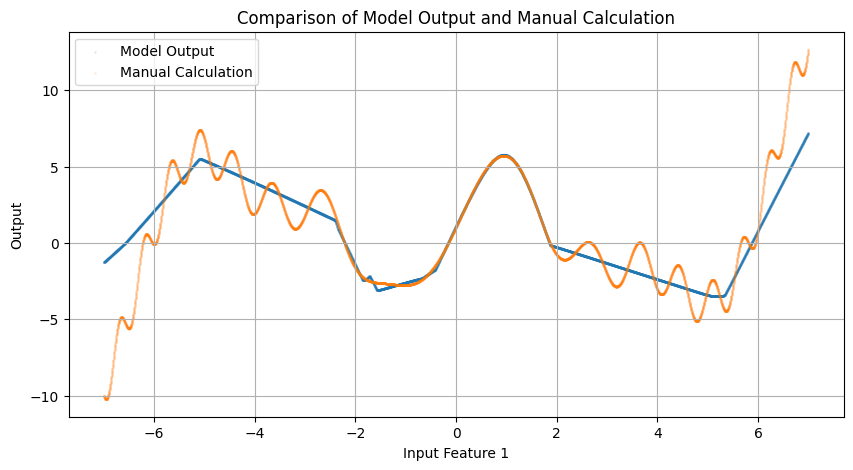

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch

num = 10000
# Generate input array from -50 to 50
x = np.linspace(-7, 7, num)  # 100 points from -50 to 50
y = np.linspace(-0, 0, num)


# Create a StandardScaler and fit it to x
# x_scaler = StandardScaler()
# x_scaler.fit(x.reshape(-1, 1))

# Generate random numbers for the 2nd and 3rd features
random_feature1 = np.linspace(-0, 0, num)  # Random data for feature 2
random_feature2 = np.linspace(-0, 0, num)  # Random data for feature 3

# Stack all features together
inputs = np.stack([x, y, random_feature1, random_feature2], axis=1)
# inputs = x_scaler.transform(inputs)
# inputs = x_scaler.transform(inputs)
inputs_tensor = torch.from_numpy(inputs).float().to(device)  # Convert to float tensor

# Ensure the model is in evaluation mode
model_prepu.eval()

# Disable gradient computation since we're only making predictions
with torch.no_grad():
    # Generate predictions from the model
    y_pred_model = model_prepu(inputs_tensor).cpu().numpy()

# Compute manual predictions
y_pred_manual = 4 * ((x ** 3 + x**2 + 1) / 100 + np.sin(x) + np.cos(x) * np.sin(x)) - x + np.cos(x ** 2) + np.sin(x ** 2)
# y_pred_manual = -8 * (1 / (1 + np.exp(-x)) - 0.25 / 2 * x) + 4
# y_pred_manual = x ** 2

# Plot both sets of predictions
plt.figure(figsize=(10, 5))
plt.scatter(x, y_pred_model.flatten(), label='Model Output', s=1, alpha=0.1)
plt.scatter(x, y_pred_manual, label='Manual Calculation', s=1, alpha=0.1)
plt.title('Comparison of Model Output and Manual Calculation')
plt.xlabel('Input Feature 1')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
evaluate_model(model_prepu, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:     7.9702 | Validation Loss:     6.7608
Epoch    2 | Train Loss:     6.5312 | Validation Loss:     6.2049
Epoch    3 | Train Loss:     4.7364 | Validation Loss:     3.0660
Epoch    4 | Train Loss:     2.7752 | Validation Loss:     2.6083
Epoch    5 | Train Loss:     2.2756 | Validation Loss:     1.8417
Epoch    6 | Train Loss:     1.3752 | Validation Loss:     0.9589
Epoch    7 | Train Loss:     0.8263 | Validation Loss:     0.7709
Epoch    8 | Train Loss:     0.7447 | Validation Loss:     0.7189
Epoch    9 | Train Loss:     0.6949 | Validation Loss:     0.6710
Epoch   10 | Train Loss:     0.6510 | Validation Loss:     0.6353
Epoch   11 | Train Loss:     0.6224 | Validation Loss:     0.6131
Epoch   12 | Train Loss:     0.6029 | Validation Loss:     0.5965
Epoch   13 | Train Loss:     0.5877 | Validation Loss:     0.5820
Epoch   14 | Train Loss:     0.5740 | Validation Loss:     0.5697
Epoch   15 | Train Loss:     0.5604 | Validation Loss:     0.5549
Epoch   16

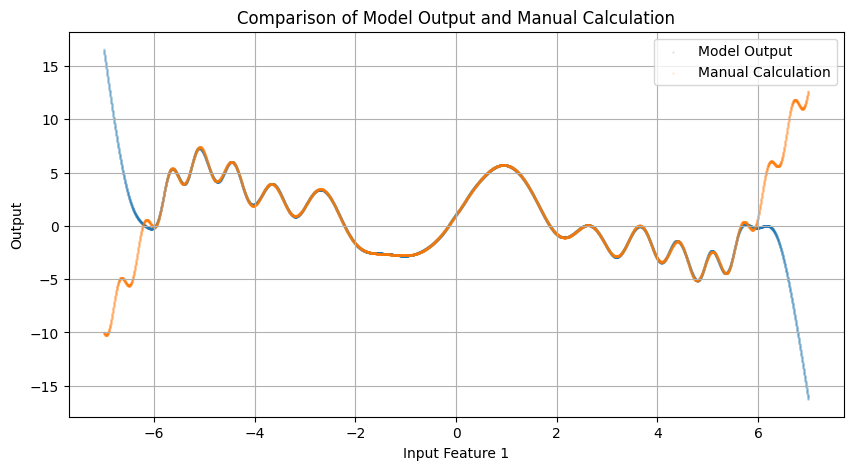

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch

num = 10000
# Generate input array from -50 to 50
x = np.linspace(-7, 7, num)  # 100 points from -50 to 50
y = np.linspace(-0, 0, num)


# Create a StandardScaler and fit it to x
# x_scaler = StandardScaler()
# x_scaler.fit(x.reshape(-1, 1))

# Generate random numbers for the 2nd and 3rd features
random_feature1 = np.linspace(-0, 0, num)  # Random data for feature 2
random_feature2 = np.linspace(-0, 0, num)  # Random data for feature 3

# Stack all features together
inputs = np.stack([x, y, random_feature1, random_feature2], axis=1)
# inputs = x_scaler.transform(inputs)
# inputs = x_scaler.transform(inputs)
inputs_tensor = torch.from_numpy(inputs).float().to(device)  # Convert to float tensor

# Ensure the model is in evaluation mode
model_prepu.eval()

# Disable gradient computation since we're only making predictions
with torch.no_grad():
    # Generate predictions from the model
    y_pred_model = model_prepu(inputs_tensor).cpu().numpy()

# Compute manual predictions
y_pred_manual = 4 * ((x ** 3 + x**2 + 1) / 100 + np.sin(x) + np.cos(x) * np.sin(x)) - x + np.cos(x ** 2) + np.sin(x ** 2)
# y_pred_manual = -8 * (1 / (1 + np.exp(-x)) - 0.25 / 2 * x) + 4
# y_pred_manual = x ** 2

# Plot both sets of predictions
plt.figure(figsize=(10, 5))
plt.scatter(x, y_pred_model.flatten(), label='Model Output', s=1, alpha=0.1)
plt.scatter(x, y_pred_manual, label='Manual Calculation', s=1, alpha=0.1)
plt.title('Comparison of Model Output and Manual Calculation')
plt.xlabel('Input Feature 1')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
for name, param in model_prepu.named_parameters():
    if "beta" in name:
        print(f"{name}: {param}")
        print()

custom_act1.betas: Parameter containing:
tensor([-1.5916e-02,  1.5446e-02, -3.0398e-04,  1.3721e-04, -6.6952e-03,
        -3.2299e-05, -7.8992e-03,  7.4928e-05, -1.2524e-02, -3.6774e-03,
         1.7925e-02,  1.4108e-02,  1.5278e-03, -2.8814e-05, -1.4483e-02,
         2.5729e-05, -1.4336e-05, -1.8948e-02, -6.0082e-05, -2.2175e-05,
         1.2179e-04,  2.4894e-05,  1.5329e-02,  2.0771e-04, -6.1574e-05,
         2.4566e-05,  1.4487e-02, -1.4051e-04, -1.3484e-02,  3.2719e-05,
        -8.8954e-06,  1.1189e-05,  8.8414e-05,  1.2189e-04,  3.4267e-05,
         3.5870e-03,  3.0173e-04,  1.6288e-02, -1.5012e-02,  1.0739e-04,
        -1.8155e-04,  1.6936e-02,  3.3852e-05, -7.5990e-05,  7.7545e-05,
        -2.4546e-03, -4.1613e-03, -3.0879e-03, -1.3204e-02,  8.7354e-05,
         1.2930e-04,  1.5464e-02,  8.0525e-03,  5.0521e-03, -9.2653e-04,
         1.6446e-02, -6.0797e-05,  1.5145e-02,  9.7977e-03, -1.2941e-04,
         1.0125e-02,  1.3674e-02, -7.8542e-07, -2.2670e-02,  1.4337e-04,
         8